**Guess the country of temples from its pictures**

# Abstract

This notebook presents the results of creating a predicitive model to tell from which country a temple is given its photograph.

The provided dataset is a zip file containing pictures of churches, mosques, monasteries and temples. The files are organized in subfolders named by the country where they are based.

Transfer Learning from a pre-trained ResNet is used in order to speedup the process of training while leveraging a state-of-the-art image model and working around with a small imbalanced dataset.

The model is estimated to have different accuracies for each country. Armenia is the worst performance (accuracy around null) while the best performance are for Russia, Germany and Thailand (accuracy around flawless). Other countries have intermediary performance (accuracy around 75%).

The model may be improved later with additional training on a larger and better balanced dataset of annotated images.

# Dependencies 

This work relies on:
- Python
- PyTorch, Torchvision, FastAI
- Google Drive (to access dataset)
- GitLab (to import custom tools created for this project)

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0" # compatibility with fastai
 
# !pip install -Uq fastai

In [2]:
from google.colab import drive
from fastai.vision import *
import pandas as pd
from sklearn.metrics import accuracy_score

Below we import custom tools made specifically for the present work.

# Dataset

The zip file containing the photos from the provided link was previously unzipped to a Google Drive. This procedure was performed in order to avoid downloading multiple times the original zip file during the development of the present notebook.

In [3]:
drive.mount('/content/drive', force_remount=True)

folder = './drive/MyDrive/train' # folder containing the provided images

!ls $folder

Mounted at /content/drive
Armenia    Hungary+Slovakia+Croatia  Malaysia+Indonesia  Spain
Australia  Indonesia-Bali	     Portugal+Brazil	 Thailand
Germany    Japan		     Russia


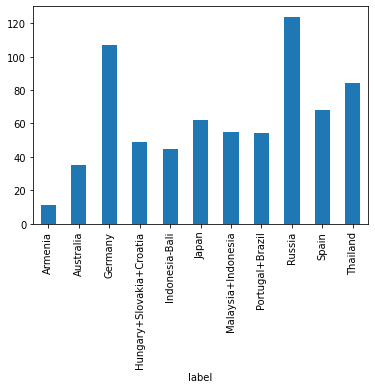

In [4]:
def df_from_data(data, get_class_function):
  filepaths = [str(i) for i in dat.items]
  labels = [get_class_function(f) for f in filepaths]
  return pd.DataFrame(np.c_[filepaths, labels], columns=['filepath', 'label'])

def get_class(filepath):
  return filepath.split('/')[-2]


dat = (ImageList.from_folder(path=folder)
        .split_none()
        .label_from_folder()
        .transform(None, size=224)
        .databunch(path='.', bs=4)
        .normalize(imagenet_stats)
       )
df = df_from_data(dat, get_class)
df.groupby('label').count().plot.bar(legend=None)
plt.gcf().patch.set_facecolor('white')

## Plot Samples

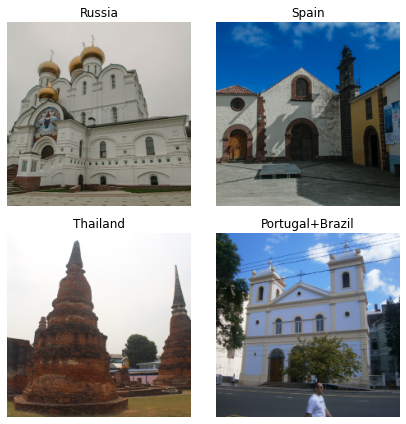

In [5]:
dat.show_batch(rows=3, figsize=(6,6))
plt.gcf().patch.set_facecolor('white')

Data Augmentation

In [6]:
trfm = get_transforms(
            do_flip=True,
            flip_vert=False,
            max_rotate=3.,
            max_zoom=1.1,
            xtra_tfms=[
              brightness(change=(0.4, 0.6), p=0.9),
              contrast(scale=(.9, 1.1), p=0.9),
              jitter(magnitude=(-0.001, 0.001)),
            ],
            )

## Split

The dataset is highly imbalanced. For this reason, the test and validation dataset are going to use the stratification technique in order to ensure a fixed amount of samples per country.

As a result, the training dataset will be the leftover after these two stratifications.

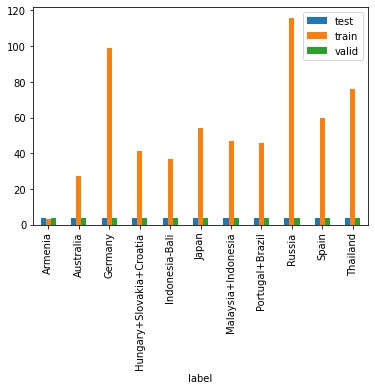

In [7]:
def stratified_split(dataframe, k = 1, *,
           origin='train', to='valid',
           new_col='dataset', create_column=True,
           ):
  if create_column: dataframe[new_col] = origin
  for cls in sorted(list(set(dataframe.label.values))):
    mask = (df.label == cls) & (df.dataset == origin)
    df_cls = df[mask].sample(k)
    df.loc[df.index.isin(df_cls.index), new_col] = to
    df[df.label == cls]

  return df

# df = df_from_data(dat, get_class)
df = stratified_split(df, k=4)
df = stratified_split(df, k=4, create_column=False, to='test')
df.groupby(['label', 'dataset']).count().unstack().plot.bar(legend=None)
plt.legend(['test', 'train', 'valid'])
plt.gcf().patch.set_facecolor('white')

In [8]:
data = (ImageList.from_folder(path=folder)
        .split_by_idxs(train_idx=df[df.dataset=='train'].index,
                       valid_idx=df[df.dataset=='valid'].index)
        .label_from_folder()
        .transform(trfm, size=224)
        .databunch(path='.', bs=4)
        .normalize(imagenet_stats)
       )

data

ImageDataBunch;

Train: LabelList (606 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Indonesia-Bali,Indonesia-Bali,Indonesia-Bali,Indonesia-Bali,Indonesia-Bali
Path: drive/MyDrive/train;

Valid: LabelList (44 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Indonesia-Bali,Indonesia-Bali,Indonesia-Bali,Indonesia-Bali,Portugal+Brazil
Path: drive/MyDrive/train;

Test: None

## Weights

In order to compensate for the imbalanced training dataset, the loss function further down will be set with class weights inversely proportional to the occurrencies of each country.

In [9]:
df_count = df.groupby('label').count()
weights = np.array([1 / df_count.loc[c, 'dataset'] for c in data.classes])
weights = weights / weights.mean()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = torch.Tensor(weights).to(device)

print('WEIGHT  COUNTRY')
for country, weight in zip(data.classes, weights):
  print('{:.3f}  '.format(weight), country)

WEIGHT  COUNTRY
3.862   Armenia
1.214   Australia
0.397   Germany
0.867   Hungary+Slovakia+Croatia
0.944   Indonesia-Bali
0.685   Japan
0.772   Malaysia+Indonesia
0.787   Portugal+Brazil
0.343   Russia
0.625   Spain
0.506   Thailand


# Model 

The predictive model is an image classifier, since we need to tell output a country (class) from an input image.

The model is derived from Resnet18 Convolutional Neural Network classifier using the Transfer Learning technique. This choice speeds up the trainig step while compensating for the small dataset size, especially considering that it was trained with some classes derived from temples variations (churches, mosques, monasteries and stupas).

The 18 number of layers is the smallest version of available ResNet options. It was chosen the less complex model in order to avoid overfitting, considering that the provided dataset is quite small.

The output layer of the pre-trained neural network needs to be changed to 11 (countries), since ResNet was originally designed for ImageNet competition with 1000 classes. 

In [10]:
learn = cnn_learner(data, models.resnet152, #models.resnet18,
                    metrics=accuracy,
                    loss_func=torch.nn.CrossEntropyLoss(weight=weights),
                    )
learn.fit_one_cycle(2)
# learn.save('mini_train')

epoch,train_loss,valid_loss,accuracy,time
0,2.474366,1.581907,0.568182,01:25
1,1.622578,1.026393,0.681818,01:24


In [11]:
learn.unfreeze()

In [15]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


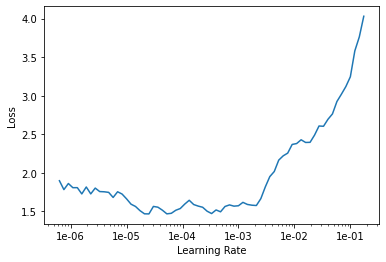

In [16]:
learn.recorder.plot()
plt.gcf().patch.set_facecolor('white')

In [14]:
stop here

SyntaxError: ignored

In [17]:
learn.fit_one_cycle(10, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.467353,1.151356,0.659091,01:25
1,1.453124,1.035990,0.681818,01:25
2,1.362283,0.997875,0.704545,01:25
3,1.199120,0.768014,0.750000,01:26
4,1.087894,0.751015,0.772727,01:25
5,0.899675,0.850783,0.704545,01:25
6,0.894627,0.637191,0.795455,01:25
7,0.786872,0.712339,0.727273,01:26
8,0.754128,0.715472,0.772727,01:25
9,0.550630,0.703916,0.772727,01:26


In [ ]:
learn.fit_one_cycle(10, max_lr=slice(1e-6, 3e-5))

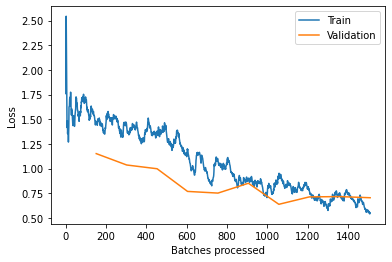

In [18]:
learn.recorder.plot_losses()
plt.gcf().patch.set_facecolor('white')

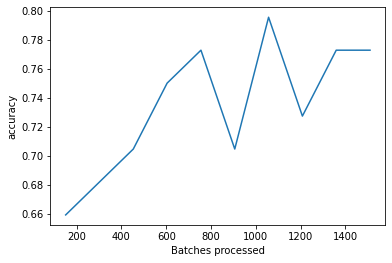

In [19]:
learn.recorder.plot_metrics()
plt.gcf().patch.set_facecolor('white')

In [ ]:
# learn.show_results()

# Performance

The test dataset is used to evaluate the performance of the trained model.

Considering that the test dataset was never seen by our model, the performance calculated in the next subsections are the expected one for all new pictures.

In [20]:
y_test = torch.tensor([data.classes.index(country)
          for country in df[df.dataset=='test']['label'].values])

test = (ImageList.from_folder(path=folder)
        .filter_by_func(lambda fname:
          df[df.filepath==str(fname)]['dataset'].values[0] == 'test')
)
data.add_test(test)

interp_test = ClassificationInterpretation.from_learner(learn, DatasetType.Test)
interp_test.y_true = y_test

## Metrics

In [21]:
accuracy_score(interp_test.y_true, interp_test.pred_class)

0.7727272727272727

The performance is not bad, especially considering that there are 11 options of countries.

However, there is room for improvement as it should obviously be as close as possible to 100%. Therefore, let's plot some more statistics to assess the possible reasons for some deterioration in performance.

## Confusion Matrix

In [22]:
interp_valid = ClassificationInterpretation.from_learner(learn, DatasetType.Valid)

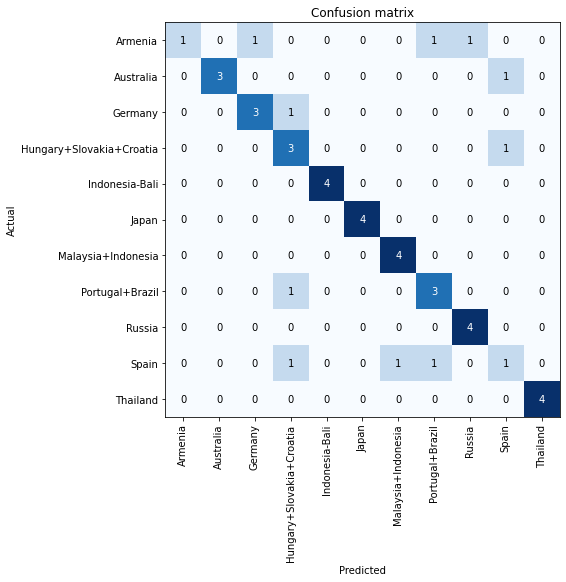

In [23]:
interp_valid.plot_confusion_matrix(figsize=(8,8))
plt.gcf().patch.set_facecolor('white')

In [24]:
interp_valid.most_confused()

[('Armenia', 'Germany', 1),
 ('Armenia', 'Portugal+Brazil', 1),
 ('Armenia', 'Russia', 1),
 ('Australia', 'Spain', 1),
 ('Germany', 'Hungary+Slovakia+Croatia', 1),
 ('Hungary+Slovakia+Croatia', 'Spain', 1),
 ('Portugal+Brazil', 'Hungary+Slovakia+Croatia', 1),
 ('Spain', 'Hungary+Slovakia+Croatia', 1),
 ('Spain', 'Malaysia+Indonesia', 1),
 ('Spain', 'Portugal+Brazil', 1)]

In [25]:
interp_test.most_confused()

[('Hungary+Slovakia+Croatia', 'Germany', 3),
 ('Armenia', 'Germany', 1),
 ('Germany', 'Hungary+Slovakia+Croatia', 1),
 ('Germany', 'Portugal+Brazil', 1),
 ('Indonesia-Bali', 'Japan', 1),
 ('Malaysia+Indonesia', 'Japan', 1),
 ('Portugal+Brazil', 'Hungary+Slovakia+Croatia', 1),
 ('Russia', 'Australia', 1)]

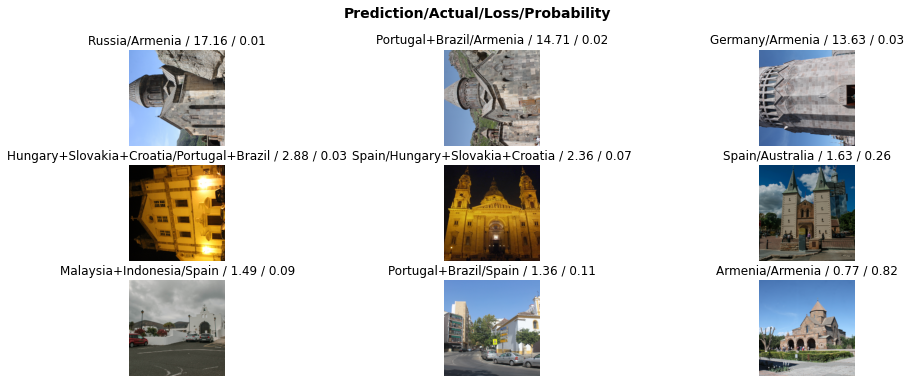

In [26]:
interp_valid.plot_top_losses(9, figsize = (16, 6))
plt.gcf().patch.set_facecolor('white')

The confusion matrix reveals some additional insights.

The worst performance is associated with Armenia. The reason is that it is the country with far less samples in the dataset, having only 3 pictures in the training dataset. As consequence, it is likely to have room for improvement by adding more pictures to the dataset.

On the other hand, the countries with the most samples (Germany, Russia and Thailand) show altogether good accuracies.

Moreover, Spain presented some misclassifications with Portugal+Brazil and vice-versa. Indeed, their temples share very similar styles, probably due to cultural and geographical proximities. The same problem of similar cultures happen less often to other pair of countries (ie: Russia and Hungary+Slovakia+Croatia, Indonesia-Bali and Malaysia+Indonisia).

Even though some images are rotated, it seems that the classification performance is not particularly worst in these cases. In fact, the original ResNet18 works the same for images upwards or rotated. Additionally, rotation was applied during the data augmentation, which helped to make it even more robust to rotations.

Additionally, the observation about the cultural proximity explained in the "Confusion Matrix" session is confirmed as one observe see above.

## Improvement

Based on all insights reported on the "Performance" section, it is concluded that the performance of the classifier can be improved by increasing the size of the training dataset.

Therefore, it is recommended as next step to collect more images of temples and separate them into folder similarly to the provided dataset.

In [27]:
# learn.export()